# BirdCLEF 2023 - W&B Hyperparameter Sweep
https://www.kaggle.com/competitions/birdclef-2023

# Setup
## Kaggle

In [1]:
from fastkaggle import setup_comp, iskaggle

comp  = 'birdclef-2023'
comp_path = setup_comp(comp, install='fastai timm fastaudio')
comp_path.ls()

(#12) [Path('birdclef-2023/train_audio_prep-2'),Path('birdclef-2023/eBird_Taxonomy_v2021.csv'),Path('birdclef-2023/test_soundscapes'),Path('birdclef-2023/train_metadata.csv'),Path('birdclef-2023/train_audio_prep-10s-10s-32k'),Path('birdclef-2023/train_audio_prep-2b'),Path('birdclef-2023/train_audio_prep-20-60s-32k'),Path('birdclef-2023/train_audio'),Path('birdclef-2023/sample_submission.csv'),Path('birdclef-2023/train_audio_prep')...]

## Imports

In [2]:
import pandas as pd

from fastai.vision.all import *
import torch
import timm
import sklearn.metrics
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit

import wandb
from fastai.callback.wandb import *
from fastcore.transform import Pipeline

from fastaudio.core.all import *
from fastaudio.augment.all import *

from pathlib import Path
import time
import pickle
import warnings
warnings.filterwarnings('ignore', category=UserWarning, message='TypedStorage is deprecated')
import yaml
import gc

print(torch.__version__)

/home/sdhca/mambaforge/envs/fastai/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


2.0.0+cu117


In [3]:
assert torch.cuda.is_available(), 'Cuda is not available!'

# Config

In [4]:
wandb_project = 'birdclef-2023-sweep'
sweep_count = 20
# wandb_group = 'eca_nfnet'

debug_on = False
lr_find_on = False
max_images = None

## Weights & Biases Sweep Setup

In [5]:
sweep_config = yaml.safe_load('''
    method: random
    early_terminate:
        type: hyperband
        min_iter: 3
    metric:
        name: error_rate
        goal: minimize
    parameters:
        # Base
        approach:
            value: Multiclass sweep
        batch_size:
            value: 8
        effective_batch_size:
            value: 64
        base_lr:
            value: 2e-2
        freeze_epochs:
            value: 1
        n_epochs:
            value: 6
        nn_arch:
            value: eca_nfnet_l0
        n_in:
            value: 1
        to_fp16:
            value: True

        #
        # Data prep details
        #
        # These aren't used here. I'm just manually capturing details from the audio prep notebook.
        # Ideally, these would be captured automatically. E.g., use yaml to set audio prep details
        # and automatically capture them for comparison in wandb.
        #
        data_prep_details:
            parameters:
                prep_dir:
                    value: train_audio_prep-10s-10s-32k
                sample_rate:
                    value: 32000
                remove_silence_type:
                    value: None
                remove_silence_threshold:
                    value: None
                min_size_ms:
                    value: None
                max_size_ms:
                    value: None
                start_size_ms:
                    value: 10000
                end_size_ms:
                    value: 10000
                train_size_ms:
                    value: 20000
                min_rating:
                    value: 2.5

        # Spectrogram creation
        spectrogram_config:
            parameters:
                sample_rate:
                    value: 32000
                n_fft:
                    values: [256, 384, 512, 768, 1024]
                # win_length:
                #     value: None
                hop_length:
                    min: 250
                    max: 1000
                f_min:
                    values: [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
                f_max:
                    value: 16000
                n_mels:
                    min: 150
                    max: 750
                power:
                    value: 1
                normalized:
                    value: False
                center:
                    value: True
                pad_mode:
                    value: reflect
                mel:
                    value: True
                to_db:
                    value: False

        # Spectrogram augmentation
        spectrogram_augmentation:
            parameters:
                add_freq_mask:
                    value: True
                freq_mask_num:
                    value: 3
                freq_mask_size:
                    value: 5
                add_time_mask:
                    value: True
                time_mask_num:
                    value: 2
                time_mask_size:
                    value: 50
                add_delta:
                    value: False
''')

# Splits & DataLoaders

In [6]:
def _get_label(df, label_col):
    return df[label_col]

get_label = partial(_get_label, label_col='primary_label')

In [7]:
def build_dataloader(config):
    
    hypp = config
    hypp_prep = config['data_prep_details']
    hypp_spec = config['spectrogram_config']
    hypp_aug = config['spectrogram_augmentation']
    
    # Load training metadata
    trn_df = pd.read_csv(comp_path/'train_metadata.csv')
    if max_images:
        trn_df = trn_df.head(n=max_images)
    
    # Set training path
    trn_path = comp_path/hypp_prep['prep_dir']
    
    # Filter audio by rating
    if hypp_prep['min_rating']:
        trn_df = trn_df[trn_df.rating >= hypp_prep['min_rating']]
        
    # Double up clsses with one instance
    solitary_labels = trn_df.pivot_table('filename', 'primary_label', aggfunc='count').query('filename==1').index.to_list()
    solitary_df = trn_df[trn_df.primary_label.isin(solitary_labels)]
    trn_df = pd.concat([trn_df, solitary_df])
    trn_df = trn_df.reset_index()
    
    # Train-test split
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
    splits = sss.split(trn_df, trn_df.primary_label)
    for trn_idx, tst_idx in splits:
        print(len(trn_idx), len(tst_idx), len(trn_idx) + len(tst_idx))
        
    # DataBlock
    cfg = AudioConfig.BasicMelSpectrogram(**hypp_spec)
    # cfg = AudioConfig.BasicMelSpectrogram(
    #     sample_rate=hypp_spec['sample_rate'],
    #     n_fft=hypp_spec['n_fft'],
    #     win_length=hypp_spec['win_length'],
    #     hop_length=hypp_spec['hop_length'],
    #     f_min=hypp_spec['f_min'],
    #     f_max=hypp_spec['f_max'],
    #     hypp_spec['win_length'],
    #     n_mels=hypp_spec['n_mels'],
    #     power=hypp_spec['power'],
    #     normalized=hypp_spec['normalized'],
    #     wkwargs=None,
    #     center=hypp_spec['center'],
    #     pad_mode=hypp_spec['pad_mode'],
    #     onesided=True,
    #     norm=None,
    #     mel=hypp_spec['mel'],
    #     to_db=hypp_spec['to_db']
    # )
    a2s = AudioToSpec.from_cfg(cfg)
    item_tfms = [a2s]
    batch_tfms = []

    # Add spectrogram augmentation
    if hypp_aug['add_freq_mask']:
        mask_freq = MaskFreq(num_masks=hypp_aug['freq_mask_num'], size=hypp_aug['freq_mask_size'])
        item_tfms.append(mask_freq)

    if hypp_aug['add_time_mask']:
        mask_time = MaskTime(num_masks=hypp_aug['time_mask_num'], size=hypp_aug['time_mask_size'])
        item_tfms.append(mask_time)

    # Create DataBlock
    db = DataBlock(blocks=(AudioBlock, CategoryBlock),
               get_x=ColReader('filename', pref=trn_path),
               get_y=get_label,
               splitter=IndexSplitter(tst_idx),
               item_tfms = item_tfms,
               batch_tfms = batch_tfms)
    
    # db.summary(trn_df)
                        
    # # DataLoaders Test
    # test_dls = db.dataloaders(trn_df, bs=1)
    # test_data = next(iter(test_dls.train))
    # print(f'test_data[0].shape: {test_data[0].shape}')
    # test_dls.show_batch()
    
    # Class weights
    class_counts = pd.value_counts(trn_df.primary_label)
    class_wt_dict = dict(1 / class_counts)
    class_wts = trn_df.primary_label.map(class_wt_dict).values
    
    # DataLoaders
    dls = db.dataloaders(
        trn_df,
        bs=hypp['batch_size'],
        num_workers=8,
        pin_memory=True,
        drop_last=False,
        wgts=class_wts
    )

    if not debug_on:
        assert len(dls.vocab) == 264, 'Some classes are not in the training set!'
        
    # Show batch
    dls.show_batch(max_n=10)
    dls.show_batch(max_n=10)
    
    return dls, trn_df, trn_idx, tst_idx
    

# Metrics
## cmAP, cmAP_probs, padded_cmAP, padded_cmAP_probs
Metrics calculated here aren't comparable to those on the Kaggle leaderboard because the proportion of real samples to padding samples differ. 

On kaggle, we have 5 padding rows for about 24,000 real rows (1:4800). Here (before any major resampling), are setting the padding factor to 1 because that already gives a higher ratio of padded rows (~1:1600)

In [8]:
from sklearn.metrics import average_precision_score

# Debugging variables and metric function
preds_test = None
labels_test = None
probs_test = None
labels_oh_test = None
padding_test = None

def cmAP_debug(preds, labels, num_classes=264):
    global preds_test
    preds_test = preds
    probs = F.one_hot(torch.argmax(preds, dim=1)).cpu().numpy()
    global probs_test
    probs_test = probs
    global labels_test
    labels_test = labels
    labels_oh = F.one_hot(labels, num_classes=num_classes).cpu().numpy()
    global labels_oh_test
    labels_oh_test = labels_oh
    return average_precision_score(labels_oh, probs, average='macro')

def padded_cmAP_debug(preds, labels, num_classes=264, padding_factor=1):
    global preds_test
    preds_test = preds
    padding = torch.ones((padding_factor, num_classes))
    global padding_test
    padding_test = padding
    probs = torch.cat((F.one_hot(torch.argmax(preds, dim=1), num_classes=num_classes).cpu(), padding)).numpy()
    global probs_test
    probs_test = probs
    labels_oh = torch.cat((F.one_hot(labels, num_classes=num_classes).cpu(), padding)).numpy()
    global labels_oh_test
    labels_oh_test = labels_oh
    return average_precision_score(labels_oh, probs, average='macro')
    # return 0.0

def cmAP(preds, labels, num_classes=264):
    probs = F.one_hot(torch.argmax(preds, dim=1), num_classes=num_classes).cpu().numpy()
    labels_oh = F.one_hot(labels, num_classes=num_classes).cpu().numpy()
    return average_precision_score(labels_oh, probs, average='macro')

def cmAP_probs(preds, labels, num_classes=264):
    probs = F.softmax(preds, dim=1).cpu().numpy()
    labels_oh = F.one_hot(labels, num_classes=num_classes).cpu().numpy()
    return average_precision_score(labels_oh, probs, average='macro')

def padded_cmAP(preds, labels, num_classes=264, padding_factor=1):
    padding = torch.ones((padding_factor, num_classes))
    probs = torch.cat((F.one_hot(torch.argmax(preds, dim=1), num_classes=num_classes).cpu(), padding)).numpy()
    labels_oh = torch.cat((F.one_hot(labels, num_classes=num_classes).cpu(), padding)).numpy()
    return average_precision_score(labels_oh, probs, average='macro')

def padded_cmAP_probs(preds, labels, num_classes=264, padding_factor=1):
    padding = torch.ones((padding_factor, num_classes))
    probs = torch.cat((F.softmax(preds, dim=1).cpu(), padding)).numpy()
    labels_oh = torch.cat((F.one_hot(labels, num_classes=num_classes).cpu(), padding)).numpy()
    return average_precision_score(labels_oh, probs, average='macro')

# We want to pad cmAP metrics once per validation epoch, not once per validation batch
padded_cmAP_score = AccumMetric(padded_cmAP, flatten=False, name='padded_cmAP')
padded_cmAP_probs_score = AccumMetric(padded_cmAP_probs, flatten=False, name='padded_cmAP_probs')

In [9]:
# Function provided here: https://www.kaggle.com/competitions/birdclef-2023/overview/evaluation

def padded_cmap_for_df(solution, submission, padding_factor=5):
    solution = solution.drop(['row_id'], axis=1, errors='ignore')
    submission = submission.drop(['row_id'], axis=1, errors='ignore')
    new_rows = []
    for i in range(padding_factor):
        new_rows.append([1 for i in range(len(solution.columns))])
    # print(new_rows)
    new_rows = pd.DataFrame(new_rows)
    new_rows.columns = solution.columns
    padded_solution = pd.concat([solution, new_rows]).reset_index(drop=True).copy()
    padded_submission = pd.concat([submission, new_rows]).reset_index(drop=True).copy()
    # print(padded_solution.shape)
    # print(padded_submission.shape)
    score = sklearn.metrics.average_precision_score(
        padded_solution.values,
        padded_submission.values,
        average='macro',
    )
    return score

## plot_metrics

In [10]:
# https://forums.fast.ai/t/plotting-metrics-after-learning/69937/3
from fastai.imports import *
from fastai.torch_core import *
from fastai.learner import *
    
@patch
@delegates(subplots)
def plot_metrics(self: Recorder, nrows=None, ncols=None, figsize=None, **kwargs):
    metrics = np.stack(self.values)
    names = self.metric_names[1:-1]
    n = len(names) - 1
    if nrows is None and ncols is None:
        nrows = int(math.sqrt(n))
        ncols = int(np.ceil(n / nrows))
    elif nrows is None: nrows = int(np.ceil(n / ncols))
    elif ncols is None: ncols = int(np.ceil(n / nrows))
    figsize = figsize or (ncols * 6, nrows * 4)
    fig, axs = subplots(nrows, ncols, figsize=figsize, **kwargs)
    axs = [ax if i < n else ax.set_axis_off() for i, ax in enumerate(axs.flatten())][:n]
    for i, (name, ax) in enumerate(zip(names, [axs[0]] + axs)):
        ax.plot(metrics[:, i], color='#1f77b4' if i == 0 else '#ff7f0e', label='valid' if i > 0 else 'train')
        ax.set_title(name if i > 1 else 'losses')
        ax.legend(loc='best')
    plt.show()

# Create Learner

In [11]:
def build_learner(dls, config):
    hypp = config

    learn = vision_learner(
        dls,
        hypp['nn_arch'],
        n_in=hypp['n_in'],
        n_out=264,
        path='.',
        metrics=[error_rate, padded_cmAP_score, padded_cmAP_probs_score]
    )

    if hypp['batch_size'] != hypp['effective_batch_size']:
        learn.add_cb(GradientAccumulation(hypp['effective_batch_size']))

    if hypp['to_fp16']:
        print('Switching to mixed precision')
        learn = learn.to_fp16()
        
    # learn.add_cb(
    #     SaveModelCallback(
    #         monitor='error_rate',
    #         fname=f"birdclef-2023-{hypp['nn_arch']}"
    #     )
    # )
        
    print(f'learn.loss_func: {learn.loss_func}')
    print(f'learn.opt_func: {learn.opt_func}')
    # learn.show_training_loop()
    
    return learn

# Train Model

In [12]:
def train(config=None):
    
    with wandb.init(config=config):
        config = wandb.config
        dls, trn_df, trn_idx, tst_idx = build_dataloader(config)
        learn = build_learner(dls, config)
        
        # LR Find
        if lr_find_on:
            learn.lr_find(suggest_funcs=(valley, minimum, steep, slide))
        
        wandb_callback = WandbCallback(log_preds=False)
        learn.add_cb(wandb_callback)
            
        # Fine Tune
        hypp = config
        learn.fine_tune(
            hypp['n_epochs'],
            freeze_epochs=hypp['freeze_epochs'], 
            base_lr=hypp['base_lr']
        )
        
        # Final scoring
        tst_df = trn_df.loc[tst_idx]
        tst_dl = learn.dls.test_dl(tst_df)
        probs, _, idxs = learn.get_preds(dl=tst_dl, with_decoded=True)
        sub_sample_df = pd.read_csv(comp_path/'sample_submission.csv')
        sub_sample_df.head()
        # 1) with binary predictions
        preds = (probs > 0.5).int()
        sub_df = pd.DataFrame(tst_df.reset_index().filename)
        sub_df.columns = ['row_id']
        sub_df = pd.concat([sub_df, pd.DataFrame(preds, columns=sub_sample_df.columns[1:])], axis=1)
        truth_df = sub_df.copy()
        truth_df.iloc[:, 1:] = 0
        for r, c in enumerate(tst_df.primary_label):
            truth_df.loc[r, c] = 1
        pcmap = padded_cmap_for_df(truth_df, sub_df)
        # 2) probability predictions
        sub_prob_df = pd.DataFrame(tst_df.reset_index().filename)
        sub_prob_df.columns = ['row_id']
        sub_prob_df = pd.concat([sub_prob_df, pd.DataFrame(probs, columns=sub_sample_df.columns[1:])], axis=1)
        pcmap_prob = padded_cmap_for_df(truth_df, sub_prob_df)
        
        # Log
        wandb.log({
            'padded_cmap': pcmap,
            'padded_cmap_probs': pcmap_prob,
        })
        
        # Clean up
        del learn
        # del config, dls, trn_df, trn_idx, tst_idx, learn, wandb_callback, hypp, tst_df, tst_dl, probs, _, idxs, sub_sample_df, preds, sub_df, truth_df, pcmap, sub_prob_df, pcmap_prob
        gc.collect()
        torch.cuda.empty_cache()

In [13]:
# print(preds_test.shape)
# print(padding_test.shape)
# print(probs_test.shape)
# print(labels_test.shape)
# print(labels_oh_test.shape)

# Launch the Sweep

Create sweep with ID: t5pcot6b
Sweep URL: https://wandb.ai/sdhca/birdclef-2023-sweep/sweeps/t5pcot6b


wandb: Agent Starting Run: 0xaksffp with config:
wandb: 	approach: Multiclass sweep
wandb: 	base_lr: 0.02
wandb: 	batch_size: 8
wandb: 	data_prep_details: {'end_size_ms': 10000, 'max_size_ms': 'None', 'min_rating': 2.5, 'min_size_ms': 'None', 'prep_dir': 'train_audio_prep-10s-10s-32k', 'remove_silence_threshold': 'None', 'remove_silence_type': 'None', 'sample_rate': 32000, 'start_size_ms': 10000, 'train_size_ms': 20000}
wandb: 	effective_batch_size: 64
wandb: 	freeze_epochs: 1
wandb: 	n_epochs: 6
wandb: 	n_in: 1
wandb: 	nn_arch: eca_nfnet_l0
wandb: 	spectrogram_augmentation: {'add_delta': False, 'add_freq_mask': True, 'add_time_mask': True, 'freq_mask_num': 3, 'freq_mask_size': 5, 'time_mask_num': 2, 'time_mask_size': 50}
wandb: 	spectrogram_config: {'center': True, 'f_max': 16000, 'f_min': 40, 'hop_length': 303, 'mel': True, 'n_fft': 384, 'n_mels': 257, 'normalized': False, 'pad_mode': 'reflect', 'power': 1, 'sample_rate': 32000, 'to_db': False}
wandb: 	to_fp16: True
wandb: Currently 

14029 1559 15588


/home/sdhca/mambaforge/envs/fastai/lib/python3.9/site-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (257) may be set too high. Or, the value for `n_freqs` (193) may be set too low.
  warnings.warn(


Switching to mixed precision
learn.loss_func: FlattenedLoss of CrossEntropyLoss()
learn.opt_func: <function Adam at 0x7f41a650da60>


epoch,train_loss,valid_loss,error_rate,padded_cmAP,padded_cmAP_probs,time
0,4.162852,3.745231,0.769083,0.342501,0.447716,02:34


epoch,train_loss,valid_loss,error_rate,padded_cmAP,padded_cmAP_probs,time
0,2.738463,2.238324,0.499679,0.423194,0.628764,05:57
1,2.340488,1.836837,0.406029,0.474559,0.696331,05:56
2,1.687380,1.402695,0.324567,0.539234,0.772272,05:56
3,1.339556,1.267153,0.284157,0.592197,0.791463,05:56
4,0.867722,1.136534,0.248877,0.618530,0.815122,05:56
5,0.744953,1.099375,0.242463,0.628324,0.823889,05:56


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eps_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
error_rate,█▄▃▂▂▁▁
lr_0,▁▂▃▆▇█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_1,▁▂▃▆▇█▂▂▂▂▃▃▄▄▄▄▅▄▄▄▄▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁
mom_0,█▇▆▄▂▁██▇▆▅▄▃▂▂▁▁▁▁▁▂▂▂▂▃▃▄▄▅▅▆▆▆▇▇▇████
mom_1,█▇▆▄▂▁██▇▆▅▄▃▂▂▁▁▁▁▁▂▂▂▂▃▃▄▄▅▅▆▆▆▇▇▇████
padded_cmAP,▁▃▄▆▇██
padded_cmAP_probs,▁▄▆▇▇██
padded_cmap,▁


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: vd1ccank with config:
wandb: 	approach: Multiclass sweep
wandb: 	base_lr: 0.02
wandb: 	batch_size: 8
wandb: 	data_prep_details: {'end_size_ms': 10000, 'max_size_ms': 'None', 'min_rating': 2.5, 'min_size_ms': 'None', 'prep_dir': 'train_audio_prep-10s-10s-32k', 'remove_silence_threshold': 'None', 'remove_silence_type': 'None', 'sample_rate': 32000, 'start_size_ms': 10000, 'train_size_ms': 20000}
wandb: 	effective_batch_size: 64
wandb: 	freeze_epochs: 1
wandb: 	n_epochs: 6
wandb: 	n_in: 1
wandb: 	nn_arch: eca_nfnet_l0
wandb: 	spectrogram_augmentation: {'add_delta': False, 'add_freq_mask': True, 'add_time_mask': True, 'freq_mask_num': 3, 'freq_mask_size': 5, 'time_mask_num': 2, 'time_mask_size': 50}
wandb: 	spectrogram_config: {'center': True, 'f_max': 16000, 'f_min': 30, 'hop_length': 879, 'mel': True, 'n_fft': 384, 'n_mels': 581, 'normalized': False, 'pad_mode': 'reflect', 'power': 1, 'sample_rate': 3200

14029 1559 15588


/home/sdhca/mambaforge/envs/fastai/lib/python3.9/site-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (581) may be set too high. Or, the value for `n_freqs` (193) may be set too low.
  warnings.warn(


Switching to mixed precision
learn.loss_func: FlattenedLoss of CrossEntropyLoss()
learn.opt_func: <function Adam at 0x7f41a650da60>


epoch,train_loss,valid_loss,error_rate,padded_cmAP,padded_cmAP_probs,time
0,4.490996,4.198881,0.856318,0.332928,0.400726,02:14


epoch,train_loss,valid_loss,error_rate,padded_cmAP,padded_cmAP_probs,time
0,3.139575,2.795772,0.596536,0.385903,0.547660,04:16
1,2.745312,2.374057,0.523412,0.404290,0.617657,04:16


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eps_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
error_rate,█▃▁
lr_0,▁▁▂▂▃▄▅▆▆▇▇██▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_1,▁▁▂▂▃▃▅▅▆▇▇██▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▄▄▄
mom_0,██▇▇▆▆▄▄▃▂▂▁▁████▇▇▇▆▆▅▅▄▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁
mom_1,██▇▇▆▆▄▄▃▂▂▁▁████▇▇▇▆▆▅▅▄▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁
padded_cmAP,▁▆█
padded_cmAP_probs,▁▆█
raw_loss,█▆▆▇▇▅▅▅▇▆▃▆▄▃▂▅▃▃▄▃▃▃▁▂▁▂▁▂▃▂▂▂▃▂▃▃▂▂▄▂


wandb: Agent Starting Run: c7c6cz0x with config:
wandb: 	approach: Multiclass sweep
wandb: 	base_lr: 0.02
wandb: 	batch_size: 8
wandb: 	data_prep_details: {'end_size_ms': 10000, 'max_size_ms': 'None', 'min_rating': 2.5, 'min_size_ms': 'None', 'prep_dir': 'train_audio_prep-10s-10s-32k', 'remove_silence_threshold': 'None', 'remove_silence_type': 'None', 'sample_rate': 32000, 'start_size_ms': 10000, 'train_size_ms': 20000}
wandb: 	effective_batch_size: 64
wandb: 	freeze_epochs: 1
wandb: 	n_epochs: 6
wandb: 	n_in: 1
wandb: 	nn_arch: eca_nfnet_l0
wandb: 	spectrogram_augmentation: {'add_delta': False, 'add_freq_mask': True, 'add_time_mask': True, 'freq_mask_num': 3, 'freq_mask_size': 5, 'time_mask_num': 2, 'time_mask_size': 50}
wandb: 	spectrogram_config: {'center': True, 'f_max': 16000, 'f_min': 50, 'hop_length': 624, 'mel': True, 'n_fft': 256, 'n_mels': 448, 'normalized': False, 'pad_mode': 'reflect', 'power': 1, 'sample_rate': 32000, 'to_db': False}
wandb: 	to_fp16: True


14029 1559 15588


/home/sdhca/mambaforge/envs/fastai/lib/python3.9/site-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (448) may be set too high. Or, the value for `n_freqs` (129) may be set too low.
  warnings.warn(


Switching to mixed precision
learn.loss_func: FlattenedLoss of CrossEntropyLoss()
learn.opt_func: <function Adam at 0x7f41a650da60>


epoch,train_loss,valid_loss,error_rate,padded_cmAP,padded_cmAP_probs,time
0,4.483329,4.181602,0.831302,0.336368,0.407632,02:14


epoch,train_loss,valid_loss,error_rate,padded_cmAP,padded_cmAP_probs,time
0,3.111068,2.732015,0.598461,0.377381,0.559925,04:27
1,2.586955,2.259742,0.493265,0.433078,0.623841,04:27
2,2.133349,1.939457,0.427838,0.475077,0.680204,04:28
3,1.783502,1.625467,0.370109,0.515481,0.731512,04:28
4,1.422424,1.491225,0.337396,0.537145,0.753456,04:27
5,1.141009,1.466128,0.332906,0.541201,0.758960,04:27


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eps_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
error_rate,█▅▃▂▂▁▁
lr_0,▁▂▃▆▇█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_1,▁▂▃▆▇█▂▂▂▂▃▃▄▄▄▄▅▄▄▄▄▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁
mom_0,█▇▆▄▂▁██▇▆▅▄▃▂▂▁▁▁▁▁▂▂▂▂▃▃▄▄▅▅▆▆▆▇▇▇████
mom_1,█▇▆▄▂▁██▇▆▅▄▃▂▂▁▁▁▁▁▂▂▂▂▃▃▄▄▅▅▆▆▆▇▇▇████
padded_cmAP,▁▂▄▆▇██
padded_cmAP_probs,▁▄▅▆▇██
padded_cmap,▁


wandb: Agent Starting Run: 1bu8rpew with config:
wandb: 	approach: Multiclass sweep
wandb: 	base_lr: 0.02
wandb: 	batch_size: 8
wandb: 	data_prep_details: {'end_size_ms': 10000, 'max_size_ms': 'None', 'min_rating': 2.5, 'min_size_ms': 'None', 'prep_dir': 'train_audio_prep-10s-10s-32k', 'remove_silence_threshold': 'None', 'remove_silence_type': 'None', 'sample_rate': 32000, 'start_size_ms': 10000, 'train_size_ms': 20000}
wandb: 	effective_batch_size: 64
wandb: 	freeze_epochs: 1
wandb: 	n_epochs: 6
wandb: 	n_in: 1
wandb: 	nn_arch: eca_nfnet_l0
wandb: 	spectrogram_augmentation: {'add_delta': False, 'add_freq_mask': True, 'add_time_mask': True, 'freq_mask_num': 3, 'freq_mask_size': 5, 'time_mask_num': 2, 'time_mask_size': 50}
wandb: 	spectrogram_config: {'center': True, 'f_max': 16000, 'f_min': 50, 'hop_length': 736, 'mel': True, 'n_fft': 1024, 'n_mels': 223, 'normalized': False, 'pad_mode': 'reflect', 'power': 1, 'sample_rate': 32000, 'to_db': False}
wandb: 	to_fp16: True


14029 1559 15588


/home/sdhca/mambaforge/envs/fastai/lib/python3.9/site-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (223) may be set too high. Or, the value for `n_freqs` (513) may be set too low.
  warnings.warn(


Switching to mixed precision
learn.loss_func: FlattenedLoss of CrossEntropyLoss()
learn.opt_func: <function Adam at 0x7f41a650da60>


epoch,train_loss,valid_loss,error_rate,padded_cmAP,padded_cmAP_probs,time
0,4.222746,3.782248,0.791533,0.336444,0.435116,02:15


epoch,train_loss,valid_loss,error_rate,padded_cmAP,padded_cmAP_probs,time
0,2.938727,2.558191,0.560616,0.392586,0.580325,02:40
1,2.494188,2.063389,0.449647,0.458455,0.660995,02:43
2,2.055561,1.663261,0.388069,0.505017,0.718788,02:41
3,1.733256,1.433135,0.327133,0.549489,0.761214,02:41
4,1.131182,1.354325,0.311097,0.560257,0.778915,02:44
5,1.035668,1.334495,0.309173,0.568846,0.781136,02:42


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eps_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
error_rate,█▅▃▂▁▁▁
lr_0,▁▂▃▆▇█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_1,▁▂▃▆▇█▂▂▂▂▃▃▄▄▄▄▅▄▄▄▄▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁
mom_0,█▇▆▄▂▁██▇▆▅▄▃▂▂▁▁▁▁▁▂▂▂▂▃▃▄▄▅▅▆▆▆▇▇▇████
mom_1,█▇▆▄▂▁██▇▆▅▄▃▂▂▁▁▁▁▁▂▂▂▂▃▃▄▄▅▅▆▆▆▇▇▇████
padded_cmAP,▁▃▅▆▇██
padded_cmAP_probs,▁▄▆▇███
padded_cmap,▁


wandb: Agent Starting Run: 17fvmrm5 with config:
wandb: 	approach: Multiclass sweep
wandb: 	base_lr: 0.02
wandb: 	batch_size: 8
wandb: 	data_prep_details: {'end_size_ms': 10000, 'max_size_ms': 'None', 'min_rating': 2.5, 'min_size_ms': 'None', 'prep_dir': 'train_audio_prep-10s-10s-32k', 'remove_silence_threshold': 'None', 'remove_silence_type': 'None', 'sample_rate': 32000, 'start_size_ms': 10000, 'train_size_ms': 20000}
wandb: 	effective_batch_size: 64
wandb: 	freeze_epochs: 1
wandb: 	n_epochs: 6
wandb: 	n_in: 1
wandb: 	nn_arch: eca_nfnet_l0
wandb: 	spectrogram_augmentation: {'add_delta': False, 'add_freq_mask': True, 'add_time_mask': True, 'freq_mask_num': 3, 'freq_mask_size': 5, 'time_mask_num': 2, 'time_mask_size': 50}
wandb: 	spectrogram_config: {'center': True, 'f_max': 16000, 'f_min': 50, 'hop_length': 768, 'mel': True, 'n_fft': 256, 'n_mels': 222, 'normalized': False, 'pad_mode': 'reflect', 'power': 1, 'sample_rate': 32000, 'to_db': False}
wandb: 	to_fp16: True


14029 1559 15588


/home/sdhca/mambaforge/envs/fastai/lib/python3.9/site-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (222) may be set too high. Or, the value for `n_freqs` (129) may be set too low.
  warnings.warn(


Switching to mixed precision
learn.loss_func: FlattenedLoss of CrossEntropyLoss()
learn.opt_func: <function Adam at 0x7f41a650da60>


epoch,train_loss,valid_loss,error_rate,padded_cmAP,padded_cmAP_probs,time
0,4.575806,4.155411,0.840282,0.331374,0.400382,02:01


epoch,train_loss,valid_loss,error_rate,padded_cmAP,padded_cmAP_probs,time
0,3.157526,2.729287,0.601026,0.378930,0.550352,02:32
1,2.739814,2.244328,0.508659,0.413298,0.624414,02:34


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eps_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
error_rate,█▃▁
lr_0,▁▁▂▂▃▄▅▆▇▇██▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_1,▁▁▂▂▃▄▅▅▇▇██▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄
mom_0,██▇▇▆▅▄▄▂▂▁▁████▇▇▇▆▆▅▅▄▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁
mom_1,██▇▇▆▅▄▄▂▂▁▁████▇▇▇▆▆▅▅▄▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁
padded_cmAP,▁▅█
padded_cmAP_probs,▁▆█
raw_loss,█▇▆▇▅█▆▅▇▆▆▆▇▆▄▃▃▇▆▃▄▅▄▅▄▃▄▄▂▄▁▄▂▄▄▃▃▂▅▁


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 0himywjt with config:
wandb: 	approach: Multiclass sweep
wandb: 	base_lr: 0.02
wandb: 	batch_size: 8
wandb: 	data_prep_details: {'end_size_ms': 10000, 'max_size_ms': 'None', 'min_rating': 2.5, 'min_size_ms': 'None', 'prep_dir': 'train_audio_prep-10s-10s-32k', 'remove_silence_threshold': 'None', 'remove_silence_type': 'None', 'sample_rate': 32000, 'start_size_ms': 10000, 'train_size_ms': 20000}
wandb: 	effective_batch_size: 64
wandb: 	freeze_epochs: 1
wandb: 	n_epochs: 6
wandb: 	n_in: 1
wandb: 	nn_arch: eca_nfnet_l0
wandb: 	spectrogram_augmentation: {'add_delta': False, 'add_freq_mask': True, 'add_time_mask': True, 'freq_mask_num': 3, 'freq_mask_size': 5, 'time_mask_num': 2, 'time_mask_size': 50}
wandb: 	spectrogram_config: {'center': True, 'f_max': 16000, 'f_min': 80, 'hop_length': 410, 'mel': True, 'n_fft': 768, 'n_mels': 209, 'normalized': False, 'pad_mode': 'reflect', 'power': 1, 'sample_rate': 3200

14029 1559 15588


/home/sdhca/mambaforge/envs/fastai/lib/python3.9/site-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (209) may be set too high. Or, the value for `n_freqs` (385) may be set too low.
  warnings.warn(


Switching to mixed precision
learn.loss_func: FlattenedLoss of CrossEntropyLoss()
learn.opt_func: <function Adam at 0x7f41a650da60>


epoch,train_loss,valid_loss,error_rate,padded_cmAP,padded_cmAP_probs,time
0,4.136387,3.501008,0.724824,0.345832,0.472746,02:24


epoch,train_loss,valid_loss,error_rate,padded_cmAP,padded_cmAP_probs,time
0,2.774101,2.331493,0.508018,0.409625,0.621879,03:34
1,2.349378,1.809662,0.418858,0.472551,0.694643,03:33
2,1.770776,1.541824,0.348300,0.520480,0.745432,03:33
3,1.229462,1.287747,0.286081,0.581555,0.789545,03:33
4,0.970570,1.211066,0.273894,0.592662,0.805115,03:33
5,0.762225,1.159963,0.255933,0.615001,0.810695,03:32


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eps_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
error_rate,█▅▃▂▁▁▁
lr_0,▁▂▃▆▇█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_1,▁▂▃▆▇█▂▂▂▂▃▃▄▄▄▄▅▄▄▄▄▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁
mom_0,█▇▆▄▂▁██▇▆▅▄▃▂▂▁▁▁▁▁▂▂▂▂▃▃▄▄▅▅▆▆▆▇▇▇████
mom_1,█▇▆▄▂▁██▇▆▅▄▃▂▂▁▁▁▁▁▂▂▂▂▃▃▄▄▅▅▆▆▆▇▇▇████
padded_cmAP,▁▃▄▆▇▇█
padded_cmAP_probs,▁▄▆▇███
padded_cmap,▁


wandb: Agent Starting Run: pjbqn93e with config:
wandb: 	approach: Multiclass sweep
wandb: 	base_lr: 0.02
wandb: 	batch_size: 8
wandb: 	data_prep_details: {'end_size_ms': 10000, 'max_size_ms': 'None', 'min_rating': 2.5, 'min_size_ms': 'None', 'prep_dir': 'train_audio_prep-10s-10s-32k', 'remove_silence_threshold': 'None', 'remove_silence_type': 'None', 'sample_rate': 32000, 'start_size_ms': 10000, 'train_size_ms': 20000}
wandb: 	effective_batch_size: 64
wandb: 	freeze_epochs: 1
wandb: 	n_epochs: 6
wandb: 	n_in: 1
wandb: 	nn_arch: eca_nfnet_l0
wandb: 	spectrogram_augmentation: {'add_delta': False, 'add_freq_mask': True, 'add_time_mask': True, 'freq_mask_num': 3, 'freq_mask_size': 5, 'time_mask_num': 2, 'time_mask_size': 50}
wandb: 	spectrogram_config: {'center': True, 'f_max': 16000, 'f_min': 90, 'hop_length': 608, 'mel': True, 'n_fft': 512, 'n_mels': 449, 'normalized': False, 'pad_mode': 'reflect', 'power': 1, 'sample_rate': 32000, 'to_db': False}
wandb: 	to_fp16: True


14029 1559 15588


/home/sdhca/mambaforge/envs/fastai/lib/python3.9/site-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (449) may be set too high. Or, the value for `n_freqs` (257) may be set too low.
  warnings.warn(


Switching to mixed precision
learn.loss_func: FlattenedLoss of CrossEntropyLoss()
learn.opt_func: <function Adam at 0x7f41a650da60>


epoch,train_loss,valid_loss,error_rate,padded_cmAP,padded_cmAP_probs,time
0,4.367365,3.920963,0.805003,0.333937,0.422336,02:21


epoch,train_loss,valid_loss,error_rate,padded_cmAP,padded_cmAP_probs,time
0,2.842560,2.441132,0.531751,0.401141,0.597896,04:54
1,2.680313,2.055321,0.453496,0.445528,0.662803,04:50


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eps_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
error_rate,█▃▁
lr_0,▁▁▂▂▃▄▅▆▆▇███▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_1,▁▁▂▂▃▄▅▅▆▇███▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▄▄▄
mom_0,██▇▇▆▅▄▄▃▂▁▁▁████▇▇▇▆▆▅▅▄▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁
mom_1,██▇▇▆▅▄▄▃▂▁▁▁████▇▇▇▆▆▅▅▄▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁
padded_cmAP,▁▅█
padded_cmAP_probs,▁▆█
raw_loss,▇█▅▇▅▇▅▇▆▅▅▃▆▄▅▄▄▃▄▃▄▄▄▃▃▁▂▂▄▁▁▂▃▁▃▂▂▃▃▅


wandb: Agent Starting Run: 90qdi8zr with config:
wandb: 	approach: Multiclass sweep
wandb: 	base_lr: 0.02
wandb: 	batch_size: 8
wandb: 	data_prep_details: {'end_size_ms': 10000, 'max_size_ms': 'None', 'min_rating': 2.5, 'min_size_ms': 'None', 'prep_dir': 'train_audio_prep-10s-10s-32k', 'remove_silence_threshold': 'None', 'remove_silence_type': 'None', 'sample_rate': 32000, 'start_size_ms': 10000, 'train_size_ms': 20000}
wandb: 	effective_batch_size: 64
wandb: 	freeze_epochs: 1
wandb: 	n_epochs: 6
wandb: 	n_in: 1
wandb: 	nn_arch: eca_nfnet_l0
wandb: 	spectrogram_augmentation: {'add_delta': False, 'add_freq_mask': True, 'add_time_mask': True, 'freq_mask_num': 3, 'freq_mask_size': 5, 'time_mask_num': 2, 'time_mask_size': 50}
wandb: 	spectrogram_config: {'center': True, 'f_max': 16000, 'f_min': 80, 'hop_length': 376, 'mel': True, 'n_fft': 256, 'n_mels': 493, 'normalized': False, 'pad_mode': 'reflect', 'power': 1, 'sample_rate': 32000, 'to_db': False}
wandb: 	to_fp16: True


14029 1559 15588


/home/sdhca/mambaforge/envs/fastai/lib/python3.9/site-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (493) may be set too high. Or, the value for `n_freqs` (129) may be set too low.
  warnings.warn(


Switching to mixed precision
learn.loss_func: FlattenedLoss of CrossEntropyLoss()
learn.opt_func: <function Adam at 0x7f41a650da60>


epoch,train_loss,valid_loss,error_rate,padded_cmAP,padded_cmAP_probs,time
0,4.524400,4.160305,0.829378,0.334117,0.414516,03:00


epoch,train_loss,valid_loss,error_rate,padded_cmAP,padded_cmAP_probs,time
0,2.926012,2.503896,0.536883,0.402409,0.590090,07:28
1,2.551662,2.005929,0.439384,0.454914,0.668754,07:25
2,2.060241,1.714845,0.375241,0.503458,0.723907,07:27
3,1.558483,1.471610,0.330340,0.539330,0.758156,07:26
4,1.078112,1.338597,0.297627,0.568881,0.784199,07:27
5,0.947145,1.299681,0.283515,0.584674,0.790907,07:25


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eps_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
error_rate,█▄▃▂▂▁▁
lr_0,▁▂▃▆▇█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_1,▁▂▃▆▇█▂▂▂▂▃▃▄▄▄▄▅▄▄▄▄▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁
mom_0,█▇▆▄▂▁██▇▆▅▄▃▂▂▁▁▁▁▁▂▂▂▂▃▃▄▄▅▅▆▆▆▇▇▇████
mom_1,█▇▆▄▂▁██▇▆▅▄▃▂▂▁▁▁▁▁▂▂▂▂▃▃▄▄▅▅▆▆▆▇▇▇████
padded_cmAP,▁▃▄▆▇██
padded_cmAP_probs,▁▄▆▇▇██
padded_cmap,▁


wandb: Agent Starting Run: h6mr5vu4 with config:
wandb: 	approach: Multiclass sweep
wandb: 	base_lr: 0.02
wandb: 	batch_size: 8
wandb: 	data_prep_details: {'end_size_ms': 10000, 'max_size_ms': 'None', 'min_rating': 2.5, 'min_size_ms': 'None', 'prep_dir': 'train_audio_prep-10s-10s-32k', 'remove_silence_threshold': 'None', 'remove_silence_type': 'None', 'sample_rate': 32000, 'start_size_ms': 10000, 'train_size_ms': 20000}
wandb: 	effective_batch_size: 64
wandb: 	freeze_epochs: 1
wandb: 	n_epochs: 6
wandb: 	n_in: 1
wandb: 	nn_arch: eca_nfnet_l0
wandb: 	spectrogram_augmentation: {'add_delta': False, 'add_freq_mask': True, 'add_time_mask': True, 'freq_mask_num': 3, 'freq_mask_size': 5, 'time_mask_num': 2, 'time_mask_size': 50}
wandb: 	spectrogram_config: {'center': True, 'f_max': 16000, 'f_min': 80, 'hop_length': 676, 'mel': True, 'n_fft': 256, 'n_mels': 442, 'normalized': False, 'pad_mode': 'reflect', 'power': 1, 'sample_rate': 32000, 'to_db': False}
wandb: 	to_fp16: True


14029 1559 15588


/home/sdhca/mambaforge/envs/fastai/lib/python3.9/site-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (442) may be set too high. Or, the value for `n_freqs` (129) may be set too low.
  warnings.warn(


Switching to mixed precision
learn.loss_func: FlattenedLoss of CrossEntropyLoss()
learn.opt_func: <function Adam at 0x7f41a650da60>


epoch,train_loss,valid_loss,error_rate,padded_cmAP,padded_cmAP_probs,time
0,4.584643,4.162450,0.860167,0.331416,0.416284,02:16


epoch,train_loss,valid_loss,error_rate,padded_cmAP,padded_cmAP_probs,time
0,3.088996,2.736335,0.592688,0.376981,0.552140,04:21
1,2.724061,2.251712,0.499038,0.418113,0.621319,04:22


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eps_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
error_rate,█▃▁
lr_0,▁▁▂▂▃▄▄▅▆▇▇██▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_1,▁▁▂▂▃▃▄▅▆▇▇██▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▄▄
mom_0,██▇▇▆▆▅▄▃▂▂▁▁████▇▇▇▆▆▆▅▅▄▄▃▃▂▂▂▁▁▁▁▁▁▁▁
mom_1,██▇▇▆▆▅▄▃▂▂▁▁████▇▇▇▆▆▆▅▅▄▄▃▃▂▂▂▁▁▁▁▁▁▁▁
padded_cmAP,▁▅█
padded_cmAP_probs,▁▆█
raw_loss,█▆▆▅▆▅▅▇▅▅▄▄▅▄▄▅▄▃▂▄▃▃▃▃▃▂▃▂▃▄▂▃▃▃▁▂▂▂▂▁


wandb: Agent Starting Run: ibcyye31 with config:
wandb: 	approach: Multiclass sweep
wandb: 	base_lr: 0.02
wandb: 	batch_size: 8
wandb: 	data_prep_details: {'end_size_ms': 10000, 'max_size_ms': 'None', 'min_rating': 2.5, 'min_size_ms': 'None', 'prep_dir': 'train_audio_prep-10s-10s-32k', 'remove_silence_threshold': 'None', 'remove_silence_type': 'None', 'sample_rate': 32000, 'start_size_ms': 10000, 'train_size_ms': 20000}
wandb: 	effective_batch_size: 64
wandb: 	freeze_epochs: 1
wandb: 	n_epochs: 6
wandb: 	n_in: 1
wandb: 	nn_arch: eca_nfnet_l0
wandb: 	spectrogram_augmentation: {'add_delta': False, 'add_freq_mask': True, 'add_time_mask': True, 'freq_mask_num': 3, 'freq_mask_size': 5, 'time_mask_num': 2, 'time_mask_size': 50}
wandb: 	spectrogram_config: {'center': True, 'f_max': 16000, 'f_min': 40, 'hop_length': 570, 'mel': True, 'n_fft': 768, 'n_mels': 586, 'normalized': False, 'pad_mode': 'reflect', 'power': 1, 'sample_rate': 32000, 'to_db': False}
wandb: 	to_fp16: True


14029 1559 15588


/home/sdhca/mambaforge/envs/fastai/lib/python3.9/site-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (586) may be set too high. Or, the value for `n_freqs` (385) may be set too low.
  warnings.warn(


Switching to mixed precision
learn.loss_func: FlattenedLoss of CrossEntropyLoss()
learn.opt_func: <function Adam at 0x7f41a650da60>


epoch,train_loss,valid_loss,error_rate,padded_cmAP,padded_cmAP_probs,time
0,4.139945,3.808379,0.783194,0.336636,0.437650,02:44


epoch,train_loss,valid_loss,error_rate,padded_cmAP,padded_cmAP_probs,time
0,2.983982,2.419922,0.525337,0.403335,0.604058,06:44
1,2.513736,1.969812,0.436818,0.468878,0.677204,06:43
2,1.869244,1.634492,0.358563,0.515756,0.736695,06:43
3,1.434726,1.452832,0.324567,0.557459,0.765232,06:43
4,1.075453,1.304490,0.286722,0.584756,0.790497,06:43
5,0.831654,1.268096,0.273252,0.601184,0.797621,06:42


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eps_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
error_rate,█▄▃▂▂▁▁
lr_0,▁▂▃▆▇█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_1,▁▂▃▆▇█▂▂▂▂▃▃▄▄▄▄▅▄▄▄▄▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁
mom_0,█▇▆▄▂▁██▇▆▅▄▃▂▂▁▁▁▁▁▂▂▂▂▃▃▄▄▅▅▆▆▆▇▇▇████
mom_1,█▇▆▄▂▁██▇▆▅▄▃▂▂▁▁▁▁▁▂▂▂▂▃▃▄▄▅▅▆▆▆▇▇▇████
padded_cmAP,▁▃▄▆▇██
padded_cmAP_probs,▁▄▆▇▇██
padded_cmap,▁


wandb: Agent Starting Run: lxvhmz4x with config:
wandb: 	approach: Multiclass sweep
wandb: 	base_lr: 0.02
wandb: 	batch_size: 8
wandb: 	data_prep_details: {'end_size_ms': 10000, 'max_size_ms': 'None', 'min_rating': 2.5, 'min_size_ms': 'None', 'prep_dir': 'train_audio_prep-10s-10s-32k', 'remove_silence_threshold': 'None', 'remove_silence_type': 'None', 'sample_rate': 32000, 'start_size_ms': 10000, 'train_size_ms': 20000}
wandb: 	effective_batch_size: 64
wandb: 	freeze_epochs: 1
wandb: 	n_epochs: 6
wandb: 	n_in: 1
wandb: 	nn_arch: eca_nfnet_l0
wandb: 	spectrogram_augmentation: {'add_delta': False, 'add_freq_mask': True, 'add_time_mask': True, 'freq_mask_num': 3, 'freq_mask_size': 5, 'time_mask_num': 2, 'time_mask_size': 50}
wandb: 	spectrogram_config: {'center': True, 'f_max': 16000, 'f_min': 70, 'hop_length': 557, 'mel': True, 'n_fft': 768, 'n_mels': 635, 'normalized': False, 'pad_mode': 'reflect', 'power': 1, 'sample_rate': 32000, 'to_db': False}
wandb: 	to_fp16: True


14029 1559 15588


/home/sdhca/mambaforge/envs/fastai/lib/python3.9/site-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (635) may be set too high. Or, the value for `n_freqs` (385) may be set too low.
  warnings.warn(
/home/sdhca/Code/fastai/fastai/torch_core.py:53: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,ax = plt.subplots(nrows, ncols, figsize=figsize, **kwargs)


Switching to mixed precision
learn.loss_func: FlattenedLoss of CrossEntropyLoss()
learn.opt_func: <function Adam at 0x7f41a650da60>


epoch,train_loss,valid_loss,error_rate,padded_cmAP,padded_cmAP_probs,time
0,4.322524,3.774165,0.776780,0.338445,0.438686,02:53


epoch,train_loss,valid_loss,error_rate,padded_cmAP,padded_cmAP_probs,time
0,2.862052,2.366034,0.506735,0.430245,0.617465,06:26
1,2.554352,1.969678,0.436177,0.450252,0.678399,06:27
2,2.135023,1.718364,0.382296,0.507083,0.726451,06:27
3,1.616085,1.451896,0.309173,0.562259,0.762493,06:26
4,1.101110,1.587594,0.285439,0.584304,0.787286,06:26
5,0.812709,1.316116,0.286081,0.583077,0.791635,06:26


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eps_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
error_rate,█▄▃▂▁▁▁
lr_0,▁▂▃▆▇█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_1,▁▂▃▆▇█▂▂▂▂▃▃▄▄▄▄▅▄▄▄▄▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁
mom_0,█▇▆▄▂▁██▇▆▅▄▃▂▂▁▁▁▁▁▂▂▂▂▃▃▄▄▅▅▆▆▆▇▇▇████
mom_1,█▇▆▄▂▁██▇▆▅▄▃▂▂▁▁▁▁▁▂▂▂▂▃▃▄▄▅▅▆▆▆▇▇▇████
padded_cmAP,▁▄▄▆▇██
padded_cmAP_probs,▁▅▆▇▇██
padded_cmap,▁


wandb: Agent Starting Run: 6t3tkqfx with config:
wandb: 	approach: Multiclass sweep
wandb: 	base_lr: 0.02
wandb: 	batch_size: 8
wandb: 	data_prep_details: {'end_size_ms': 10000, 'max_size_ms': 'None', 'min_rating': 2.5, 'min_size_ms': 'None', 'prep_dir': 'train_audio_prep-10s-10s-32k', 'remove_silence_threshold': 'None', 'remove_silence_type': 'None', 'sample_rate': 32000, 'start_size_ms': 10000, 'train_size_ms': 20000}
wandb: 	effective_batch_size: 64
wandb: 	freeze_epochs: 1
wandb: 	n_epochs: 6
wandb: 	n_in: 1
wandb: 	nn_arch: eca_nfnet_l0
wandb: 	spectrogram_augmentation: {'add_delta': False, 'add_freq_mask': True, 'add_time_mask': True, 'freq_mask_num': 3, 'freq_mask_size': 5, 'time_mask_num': 2, 'time_mask_size': 50}
wandb: 	spectrogram_config: {'center': True, 'f_max': 16000, 'f_min': 40, 'hop_length': 309, 'mel': True, 'n_fft': 1024, 'n_mels': 310, 'normalized': False, 'pad_mode': 'reflect', 'power': 1, 'sample_rate': 32000, 'to_db': False}
wandb: 	to_fp16: True


14029 1559 15588


/home/sdhca/mambaforge/envs/fastai/lib/python3.9/site-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (310) may be set too high. Or, the value for `n_freqs` (513) may be set too low.
  warnings.warn(


Switching to mixed precision
learn.loss_func: FlattenedLoss of CrossEntropyLoss()
learn.opt_func: <function Adam at 0x7f41a650da60>


epoch,train_loss,valid_loss,error_rate,padded_cmAP,padded_cmAP_probs,time
0,3.997899,3.496554,0.739577,0.333461,0.468462,02:55


epoch,train_loss,valid_loss,error_rate,padded_cmAP,padded_cmAP_probs,time
0,2.746057,2.210878,0.482360,0.428886,0.633033,06:07
1,2.076392,1.780308,0.395767,0.475936,0.707199,06:07
2,1.720816,1.474473,0.333547,0.528820,0.760758,06:07
3,1.335040,1.231456,0.289929,0.580135,0.801000,06:07
4,0.894376,1.115460,0.242463,0.629199,0.824948,06:07
5,0.575606,1.075466,0.251443,0.613918,0.829719,06:07


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eps_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
error_rate,█▄▃▂▂▁▁
lr_0,▁▂▃▆▇█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_1,▁▂▃▆▇█▂▂▂▂▃▃▄▄▄▄▅▄▄▄▄▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁
mom_0,█▇▆▄▂▁██▇▆▅▄▃▂▂▁▁▁▁▁▂▂▂▂▃▃▄▄▅▅▆▆▆▇▇▇████
mom_1,█▇▆▄▂▁██▇▆▅▄▃▂▂▁▁▁▁▁▂▂▂▂▃▃▄▄▅▅▆▆▆▇▇▇████
padded_cmAP,▁▃▄▆▇██
padded_cmAP_probs,▁▄▆▇▇██
padded_cmap,▁


wandb: Agent Starting Run: 4jv6n1t9 with config:
wandb: 	approach: Multiclass sweep
wandb: 	base_lr: 0.02
wandb: 	batch_size: 8
wandb: 	data_prep_details: {'end_size_ms': 10000, 'max_size_ms': 'None', 'min_rating': 2.5, 'min_size_ms': 'None', 'prep_dir': 'train_audio_prep-10s-10s-32k', 'remove_silence_threshold': 'None', 'remove_silence_type': 'None', 'sample_rate': 32000, 'start_size_ms': 10000, 'train_size_ms': 20000}
wandb: 	effective_batch_size: 64
wandb: 	freeze_epochs: 1
wandb: 	n_epochs: 6
wandb: 	n_in: 1
wandb: 	nn_arch: eca_nfnet_l0
wandb: 	spectrogram_augmentation: {'add_delta': False, 'add_freq_mask': True, 'add_time_mask': True, 'freq_mask_num': 3, 'freq_mask_size': 5, 'time_mask_num': 2, 'time_mask_size': 50}
wandb: 	spectrogram_config: {'center': True, 'f_max': 16000, 'f_min': 90, 'hop_length': 684, 'mel': True, 'n_fft': 384, 'n_mels': 155, 'normalized': False, 'pad_mode': 'reflect', 'power': 1, 'sample_rate': 32000, 'to_db': False}
wandb: 	to_fp16: True


14029 1559 15588


/home/sdhca/mambaforge/envs/fastai/lib/python3.9/site-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (155) may be set too high. Or, the value for `n_freqs` (193) may be set too low.
  warnings.warn(


Switching to mixed precision
learn.loss_func: FlattenedLoss of CrossEntropyLoss()
learn.opt_func: <function Adam at 0x7f41a650da60>


epoch,train_loss,valid_loss,error_rate,padded_cmAP,padded_cmAP_probs,time
0,4.287549,3.973678,0.812059,0.336129,0.424341,02:07


epoch,train_loss,valid_loss,error_rate,padded_cmAP,padded_cmAP_probs,time
0,3.137852,2.576739,0.571520,0.394087,0.589114,02:30
1,2.756593,2.156919,0.483002,0.430158,0.645063,02:31


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eps_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
error_rate,█▃▁
lr_0,▁▁▂▂▃▄▄▅▆▇▇██▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_1,▁▁▂▂▃▃▄▅▆▇▇██▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▄▄
mom_0,██▇▇▆▆▅▄▃▂▂▁▁████▇▇▇▆▆▆▅▅▄▄▃▃▂▂▂▁▁▁▁▁▁▁▁
mom_1,██▇▇▆▆▅▄▃▂▂▁▁████▇▇▇▆▆▆▅▅▄▄▃▃▂▂▂▁▁▁▁▁▁▁▁
padded_cmAP,▁▅█
padded_cmAP_probs,▁▆█
raw_loss,█▇▆▅▅▅▄▇▆▆▅▃▅▄▄▅▄▄▅▄▃▃▃▂▁▄▄▁▁▄▂▃▂▄▃▃▃▂▄▂


wandb: Agent Starting Run: ff3424vh with config:
wandb: 	approach: Multiclass sweep
wandb: 	base_lr: 0.02
wandb: 	batch_size: 8
wandb: 	data_prep_details: {'end_size_ms': 10000, 'max_size_ms': 'None', 'min_rating': 2.5, 'min_size_ms': 'None', 'prep_dir': 'train_audio_prep-10s-10s-32k', 'remove_silence_threshold': 'None', 'remove_silence_type': 'None', 'sample_rate': 32000, 'start_size_ms': 10000, 'train_size_ms': 20000}
wandb: 	effective_batch_size: 64
wandb: 	freeze_epochs: 1
wandb: 	n_epochs: 6
wandb: 	n_in: 1
wandb: 	nn_arch: eca_nfnet_l0
wandb: 	spectrogram_augmentation: {'add_delta': False, 'add_freq_mask': True, 'add_time_mask': True, 'freq_mask_num': 3, 'freq_mask_size': 5, 'time_mask_num': 2, 'time_mask_size': 50}
wandb: 	spectrogram_config: {'center': True, 'f_max': 16000, 'f_min': 10, 'hop_length': 783, 'mel': True, 'n_fft': 384, 'n_mels': 396, 'normalized': False, 'pad_mode': 'reflect', 'power': 1, 'sample_rate': 32000, 'to_db': False}
wandb: 	to_fp16: True


14029 1559 15588


/home/sdhca/mambaforge/envs/fastai/lib/python3.9/site-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (396) may be set too high. Or, the value for `n_freqs` (193) may be set too low.
  warnings.warn(


Switching to mixed precision
learn.loss_func: FlattenedLoss of CrossEntropyLoss()
learn.opt_func: <function Adam at 0x7f41a650da60>


epoch,train_loss,valid_loss,error_rate,padded_cmAP,padded_cmAP_probs,time
0,4.352852,4.027046,0.838358,0.331080,0.422982,02:15


epoch,train_loss,valid_loss,error_rate,padded_cmAP,padded_cmAP_probs,time
0,3.110871,2.658307,0.572803,0.395415,0.570329,03:40
1,2.734507,2.290915,0.504169,0.423060,0.622728,03:41


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eps_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
error_rate,█▂▁
lr_0,▁▁▂▂▃▄▅▆▇▇██▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_1,▁▁▂▂▃▄▅▅▇▇██▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄
mom_0,██▇▇▆▅▄▄▂▂▁▁████▇▇▇▆▆▅▅▄▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁
mom_1,██▇▇▆▅▄▄▂▂▁▁████▇▇▇▆▆▅▅▄▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁
padded_cmAP,▁▆█
padded_cmAP_probs,▁▆█
raw_loss,█▇▇▅▅▅▆▅▅▅▄▄▄▄▄▅▃▃▄▃▅▂▃▃▃▃▃▂▂▃▃▁▃▂▂▁▂▂▂▁


wandb: Agent Starting Run: 6n0fddkd with config:
wandb: 	approach: Multiclass sweep
wandb: 	base_lr: 0.02
wandb: 	batch_size: 8
wandb: 	data_prep_details: {'end_size_ms': 10000, 'max_size_ms': 'None', 'min_rating': 2.5, 'min_size_ms': 'None', 'prep_dir': 'train_audio_prep-10s-10s-32k', 'remove_silence_threshold': 'None', 'remove_silence_type': 'None', 'sample_rate': 32000, 'start_size_ms': 10000, 'train_size_ms': 20000}
wandb: 	effective_batch_size: 64
wandb: 	freeze_epochs: 1
wandb: 	n_epochs: 6
wandb: 	n_in: 1
wandb: 	nn_arch: eca_nfnet_l0
wandb: 	spectrogram_augmentation: {'add_delta': False, 'add_freq_mask': True, 'add_time_mask': True, 'freq_mask_num': 3, 'freq_mask_size': 5, 'time_mask_num': 2, 'time_mask_size': 50}
wandb: 	spectrogram_config: {'center': True, 'f_max': 16000, 'f_min': 60, 'hop_length': 304, 'mel': True, 'n_fft': 768, 'n_mels': 736, 'normalized': False, 'pad_mode': 'reflect', 'power': 1, 'sample_rate': 32000, 'to_db': False}
wandb: 	to_fp16: True


14029 1559 15588


/home/sdhca/mambaforge/envs/fastai/lib/python3.9/site-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (736) may be set too high. Or, the value for `n_freqs` (385) may be set too low.
  warnings.warn(


Switching to mixed precision
learn.loss_func: FlattenedLoss of CrossEntropyLoss()
learn.opt_func: <function Adam at 0x7f41a650da60>


epoch,train_loss,valid_loss,error_rate,padded_cmAP,padded_cmAP_probs,time
0,4.052423,3.603939,0.754330,0.336229,0.463125,04:46


epoch,train_loss,valid_loss,error_rate,padded_cmAP,padded_cmAP_probs,time
0,2.774543,2.224727,0.484926,0.432001,0.634160,12:39
1,2.373118,1.815350,0.402181,0.487895,0.703578,12:39
2,1.885399,1.588851,0.342527,0.534534,0.746660,12:39
3,1.212033,1.266003,0.288647,0.586772,0.805714,12:38
4,0.900847,1.171085,0.262348,0.610432,0.823090,12:39
5,0.684553,1.167226,0.250160,0.627477,0.822990,12:38


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eps_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
error_rate,█▄▃▂▂▁▁
lr_0,▁▂▃▆▇█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_1,▁▂▃▆▇█▂▂▂▂▃▃▄▄▄▄▅▄▄▄▄▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁
mom_0,█▇▆▄▂▁██▇▆▅▄▃▂▂▁▁▁▁▁▂▂▂▂▃▃▄▄▅▅▆▆▆▇▇▇████
mom_1,█▇▆▄▂▁██▇▆▅▄▃▂▂▁▁▁▁▁▂▂▂▂▃▃▄▄▅▅▆▆▆▇▇▇████
padded_cmAP,▁▃▅▆▇██
padded_cmAP_probs,▁▄▆▇███
padded_cmap,▁


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: i1o9qzgq with config:
wandb: 	approach: Multiclass sweep
wandb: 	base_lr: 0.02
wandb: 	batch_size: 8
wandb: 	data_prep_details: {'end_size_ms': 10000, 'max_size_ms': 'None', 'min_rating': 2.5, 'min_size_ms': 'None', 'prep_dir': 'train_audio_prep-10s-10s-32k', 'remove_silence_threshold': 'None', 'remove_silence_type': 'None', 'sample_rate': 32000, 'start_size_ms': 10000, 'train_size_ms': 20000}
wandb: 	effective_batch_size: 64
wandb: 	freeze_epochs: 1
wandb: 	n_epochs: 6
wandb: 	n_in: 1
wandb: 	nn_arch: eca_nfnet_l0
wandb: 	spectrogram_augmentation: {'add_delta': False, 'add_freq_mask': True, 'add_time_mask': True, 'freq_mask_num': 3, 'freq_mask_size': 5, 'time_mask_num': 2, 'time_mask_size': 50}
wandb: 	spectrogram_config: {'center': True, 'f_max': 16000, 'f_min': 50, 'hop_length': 261, 'mel': True, 'n_fft': 1024, 'n_mels': 175, 'normalized': False, 'pad_mode': 'reflect', 'power': 1, 'sample_rate': 320

14029 1559 15588


/home/sdhca/mambaforge/envs/fastai/lib/python3.9/site-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (175) may be set too high. Or, the value for `n_freqs` (513) may be set too low.
  warnings.warn(


Switching to mixed precision
learn.loss_func: FlattenedLoss of CrossEntropyLoss()
learn.opt_func: <function Adam at 0x7f41a650da60>


epoch,train_loss,valid_loss,error_rate,padded_cmAP,padded_cmAP_probs,time
0,3.894991,3.524915,0.722899,0.340423,0.465089,02:51


epoch,train_loss,valid_loss,error_rate,padded_cmAP,padded_cmAP_probs,time
0,2.662503,2.237710,0.492623,0.410481,0.624782,04:24
1,2.219593,1.756929,0.393201,0.483943,0.713697,04:24
2,1.737014,1.405674,0.317511,0.541192,0.766938,04:23
3,1.290418,1.243437,0.280308,0.586343,0.801179,04:25
4,0.858418,1.122343,0.245029,0.625038,0.821107,04:24
5,0.629127,1.101829,0.243746,0.626751,0.822029,04:24


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eps_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
error_rate,█▅▃▂▂▁▁
lr_0,▁▂▃▆▇█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_1,▁▂▃▆▇█▂▂▂▂▃▃▄▄▄▄▅▄▄▄▄▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁
mom_0,█▇▆▄▂▁██▇▆▅▄▃▂▂▁▁▁▁▁▂▂▂▂▃▃▄▄▅▅▆▆▆▇▇▇████
mom_1,█▇▆▄▂▁██▇▆▅▄▃▂▂▁▁▁▁▁▂▂▂▂▃▃▄▄▅▅▆▆▆▇▇▇████
padded_cmAP,▁▃▅▆▇██
padded_cmAP_probs,▁▄▆▇███
padded_cmap,▁


wandb: Agent Starting Run: em8rnsxd with config:
wandb: 	approach: Multiclass sweep
wandb: 	base_lr: 0.02
wandb: 	batch_size: 8
wandb: 	data_prep_details: {'end_size_ms': 10000, 'max_size_ms': 'None', 'min_rating': 2.5, 'min_size_ms': 'None', 'prep_dir': 'train_audio_prep-10s-10s-32k', 'remove_silence_threshold': 'None', 'remove_silence_type': 'None', 'sample_rate': 32000, 'start_size_ms': 10000, 'train_size_ms': 20000}
wandb: 	effective_batch_size: 64
wandb: 	freeze_epochs: 1
wandb: 	n_epochs: 6
wandb: 	n_in: 1
wandb: 	nn_arch: eca_nfnet_l0
wandb: 	spectrogram_augmentation: {'add_delta': False, 'add_freq_mask': True, 'add_time_mask': True, 'freq_mask_num': 3, 'freq_mask_size': 5, 'time_mask_num': 2, 'time_mask_size': 50}
wandb: 	spectrogram_config: {'center': True, 'f_max': 16000, 'f_min': 10, 'hop_length': 714, 'mel': True, 'n_fft': 1024, 'n_mels': 625, 'normalized': False, 'pad_mode': 'reflect', 'power': 1, 'sample_rate': 32000, 'to_db': False}
wandb: 	to_fp16: True


14029 1559 15588


/home/sdhca/mambaforge/envs/fastai/lib/python3.9/site-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (625) may be set too high. Or, the value for `n_freqs` (513) may be set too low.
  warnings.warn(


Switching to mixed precision
learn.loss_func: FlattenedLoss of CrossEntropyLoss()
learn.opt_func: <function Adam at 0x7f41a650da60>


epoch,train_loss,valid_loss,error_rate,padded_cmAP,padded_cmAP_probs,time
0,4.295064,3.869636,0.791533,0.336486,0.433081,02:41


epoch,train_loss,valid_loss,error_rate,padded_cmAP,padded_cmAP_probs,time
0,2.982001,2.471653,0.547146,0.404906,0.592544,05:54
1,2.489324,2.055294,0.456703,0.464315,0.665222,05:54


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eps_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
error_rate,█▃▁
lr_0,▁▁▂▂▃▄▅▆▆▇███▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_1,▁▁▂▂▃▄▅▅▆▇███▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄
mom_0,██▇▇▆▅▄▄▃▂▁▁▁████▇▇▆▆▆▅▅▄▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁
mom_1,██▇▇▆▅▄▄▃▂▁▁▁████▇▇▆▆▆▅▅▄▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁
padded_cmAP,▁▅█
padded_cmAP_probs,▁▆█
raw_loss,▇▇▆▆▄█▅▇▄▅▅▅▅▄▃▃▄▄▃▄▄▂▄▄▃▂▃▂▂▃▂▁▂▁▄▃▃▃▄▂


wandb: Agent Starting Run: 18dovyl9 with config:
wandb: 	approach: Multiclass sweep
wandb: 	base_lr: 0.02
wandb: 	batch_size: 8
wandb: 	data_prep_details: {'end_size_ms': 10000, 'max_size_ms': 'None', 'min_rating': 2.5, 'min_size_ms': 'None', 'prep_dir': 'train_audio_prep-10s-10s-32k', 'remove_silence_threshold': 'None', 'remove_silence_type': 'None', 'sample_rate': 32000, 'start_size_ms': 10000, 'train_size_ms': 20000}
wandb: 	effective_batch_size: 64
wandb: 	freeze_epochs: 1
wandb: 	n_epochs: 6
wandb: 	n_in: 1
wandb: 	nn_arch: eca_nfnet_l0
wandb: 	spectrogram_augmentation: {'add_delta': False, 'add_freq_mask': True, 'add_time_mask': True, 'freq_mask_num': 3, 'freq_mask_size': 5, 'time_mask_num': 2, 'time_mask_size': 50}
wandb: 	spectrogram_config: {'center': True, 'f_max': 16000, 'f_min': 40, 'hop_length': 667, 'mel': True, 'n_fft': 512, 'n_mels': 725, 'normalized': False, 'pad_mode': 'reflect', 'power': 1, 'sample_rate': 32000, 'to_db': False}
wandb: 	to_fp16: True


14029 1559 15588


/home/sdhca/mambaforge/envs/fastai/lib/python3.9/site-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (725) may be set too high. Or, the value for `n_freqs` (257) may be set too low.
  warnings.warn(


Switching to mixed precision
learn.loss_func: FlattenedLoss of CrossEntropyLoss()
learn.opt_func: <function Adam at 0x7f41a650da60>


epoch,train_loss,valid_loss,error_rate,padded_cmAP,padded_cmAP_probs,time
0,4.348261,4.102853,0.830019,0.329349,0.409988,02:41


epoch,train_loss,valid_loss,error_rate,padded_cmAP,padded_cmAP_probs,time
0,2.993599,2.642470,0.560616,0.389296,0.569113,06:20
1,2.660677,2.209085,0.491341,0.425458,0.631028,06:20


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eps_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
error_rate,█▂▁
lr_0,▁▁▂▂▃▄▄▅▆▇▇██▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_1,▁▁▂▂▃▃▄▅▆▇▇██▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▄▄
mom_0,██▇▇▆▆▅▄▃▂▂▁▁████▇▇▇▆▆▆▅▅▄▄▃▃▃▂▂▂▁▁▁▁▁▁▁
mom_1,██▇▇▆▆▅▄▃▂▂▁▁████▇▇▇▆▆▆▅▅▄▄▃▃▃▂▂▂▁▁▁▁▁▁▁
padded_cmAP,▁▅█
padded_cmAP_probs,▁▆█
raw_loss,█▇█▇▇▆▇█▅▇▆▅▅▄▅▅▄▅▂▄▄▁▁▂▁▃▄▁▄▃▃▃▂▃▃▂▄▃▁▂


wandb: Agent Starting Run: r6i6laby with config:
wandb: 	approach: Multiclass sweep
wandb: 	base_lr: 0.02
wandb: 	batch_size: 8
wandb: 	data_prep_details: {'end_size_ms': 10000, 'max_size_ms': 'None', 'min_rating': 2.5, 'min_size_ms': 'None', 'prep_dir': 'train_audio_prep-10s-10s-32k', 'remove_silence_threshold': 'None', 'remove_silence_type': 'None', 'sample_rate': 32000, 'start_size_ms': 10000, 'train_size_ms': 20000}
wandb: 	effective_batch_size: 64
wandb: 	freeze_epochs: 1
wandb: 	n_epochs: 6
wandb: 	n_in: 1
wandb: 	nn_arch: eca_nfnet_l0
wandb: 	spectrogram_augmentation: {'add_delta': False, 'add_freq_mask': True, 'add_time_mask': True, 'freq_mask_num': 3, 'freq_mask_size': 5, 'time_mask_num': 2, 'time_mask_size': 50}
wandb: 	spectrogram_config: {'center': True, 'f_max': 16000, 'f_min': 30, 'hop_length': 642, 'mel': True, 'n_fft': 1024, 'n_mels': 643, 'normalized': False, 'pad_mode': 'reflect', 'power': 1, 'sample_rate': 32000, 'to_db': False}
wandb: 	to_fp16: True


14029 1559 15588


/home/sdhca/mambaforge/envs/fastai/lib/python3.9/site-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (643) may be set too high. Or, the value for `n_freqs` (513) may be set too low.
  warnings.warn(


Switching to mixed precision
learn.loss_func: FlattenedLoss of CrossEntropyLoss()
learn.opt_func: <function Adam at 0x7f41a650da60>


epoch,train_loss,valid_loss,error_rate,padded_cmAP,padded_cmAP_probs,time
0,4.183864,3.786605,0.783836,0.337642,0.438517,03:00


epoch,train_loss,valid_loss,error_rate,padded_cmAP,padded_cmAP_probs,time
0,2.873868,2.422906,0.541373,0.402090,0.609183,07:20
1,2.524698,2.013111,0.448364,0.447478,0.675725,07:20


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eps_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
error_rate,█▃▁
lr_0,▁▁▂▂▃▄▄▅▆▇▇██▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_1,▁▁▂▂▃▃▄▅▆▇▇██▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▄▄
mom_0,██▇▇▆▆▅▄▃▂▂▁▁████▇▇▇▆▆▆▅▅▄▄▃▃▃▂▂▂▁▁▁▁▁▁▁
mom_1,██▇▇▆▆▅▄▃▂▂▁▁████▇▇▇▆▆▆▅▅▄▄▃▃▃▂▂▂▁▁▁▁▁▁▁
padded_cmAP,▁▅█
padded_cmAP_probs,▁▆█
raw_loss,█▇▇▇▇▅▇▇▅▆▄▅▃▄▄▄▃▂▂▅▂▃▃▂▁▃▃▂▃▃▃▄▃▂▂▄▃▁▄▁


wandb: Agent Starting Run: y6qcruio with config:
wandb: 	approach: Multiclass sweep
wandb: 	base_lr: 0.02
wandb: 	batch_size: 8
wandb: 	data_prep_details: {'end_size_ms': 10000, 'max_size_ms': 'None', 'min_rating': 2.5, 'min_size_ms': 'None', 'prep_dir': 'train_audio_prep-10s-10s-32k', 'remove_silence_threshold': 'None', 'remove_silence_type': 'None', 'sample_rate': 32000, 'start_size_ms': 10000, 'train_size_ms': 20000}
wandb: 	effective_batch_size: 64
wandb: 	freeze_epochs: 1
wandb: 	n_epochs: 6
wandb: 	n_in: 1
wandb: 	nn_arch: eca_nfnet_l0
wandb: 	spectrogram_augmentation: {'add_delta': False, 'add_freq_mask': True, 'add_time_mask': True, 'freq_mask_num': 3, 'freq_mask_size': 5, 'time_mask_num': 2, 'time_mask_size': 50}
wandb: 	spectrogram_config: {'center': True, 'f_max': 16000, 'f_min': 80, 'hop_length': 282, 'mel': True, 'n_fft': 768, 'n_mels': 361, 'normalized': False, 'pad_mode': 'reflect', 'power': 1, 'sample_rate': 32000, 'to_db': False}
wandb: 	to_fp16: True


14029 1559 15588


/home/sdhca/mambaforge/envs/fastai/lib/python3.9/site-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (361) may be set too high. Or, the value for `n_freqs` (385) may be set too low.
  warnings.warn(


Switching to mixed precision
learn.loss_func: FlattenedLoss of CrossEntropyLoss()
learn.opt_func: <function Adam at 0x7f41a650da60>


epoch,train_loss,valid_loss,error_rate,padded_cmAP,padded_cmAP_probs,time
0,3.980136,3.473234,0.714561,0.352271,0.472563,03:12


epoch,train_loss,valid_loss,error_rate,padded_cmAP,padded_cmAP_probs,time
0,2.559396,2.173632,0.465042,0.430980,0.642289,07:34
1,2.305712,1.739987,0.401539,0.477443,0.707583,07:35
2,1.781214,1.387067,0.314945,0.549586,0.770299,07:35
3,1.200057,1.223956,0.286722,0.581089,0.812169,07:34
4,0.811465,1.090688,0.241180,0.621530,0.827327,07:35
5,0.608880,1.073973,0.232200,0.636518,0.830371,07:34


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eps_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
error_rate,█▄▃▂▂▁▁
lr_0,▁▂▃▆▇█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_1,▁▂▃▆▇█▂▂▂▂▃▃▄▄▄▄▅▄▄▄▄▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁
mom_0,█▇▆▄▂▁██▇▆▅▄▃▂▂▁▁▁▁▁▂▂▂▂▃▃▄▄▅▅▆▆▆▇▇▇████
mom_1,█▇▆▄▂▁██▇▆▅▄▃▂▂▁▁▁▁▁▂▂▂▂▃▃▄▄▅▅▆▆▆▇▇▇████
padded_cmAP,▁▃▄▆▇██
padded_cmAP_probs,▁▄▆▇███
padded_cmap,▁


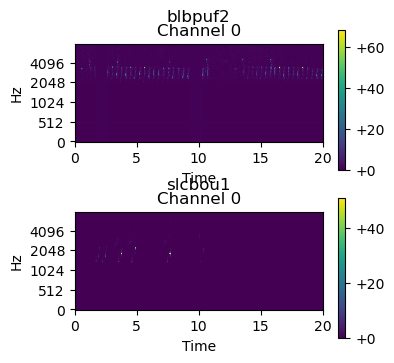

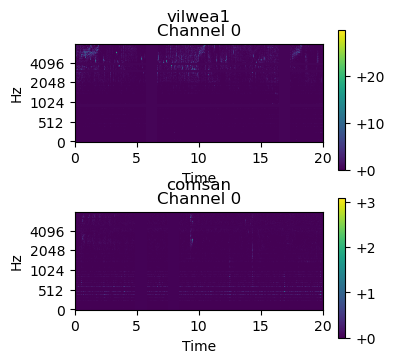

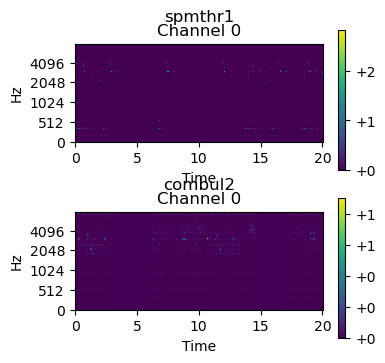

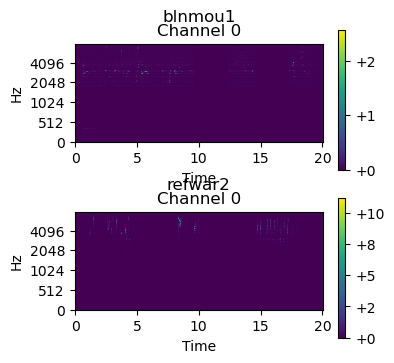

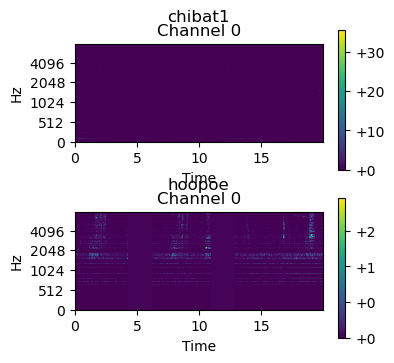

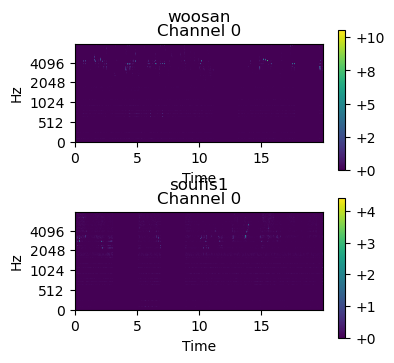

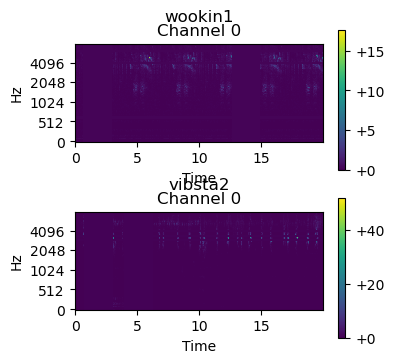

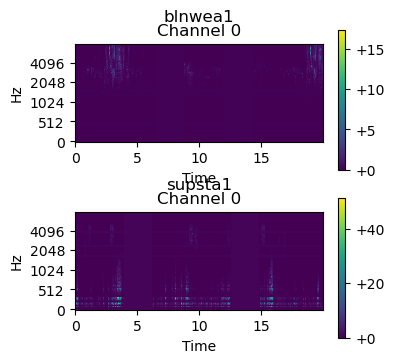

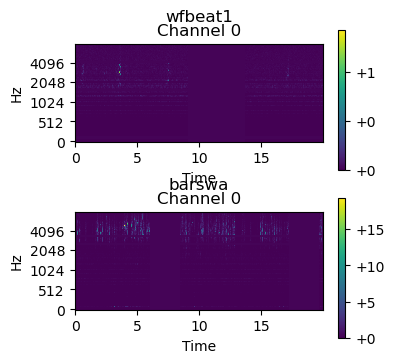

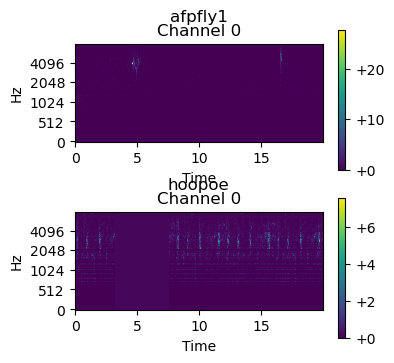

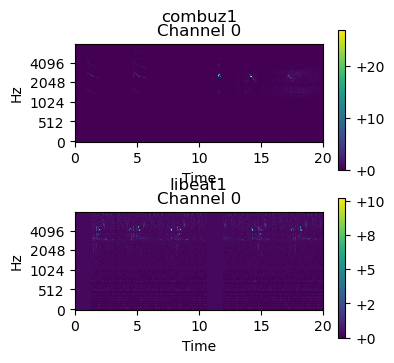

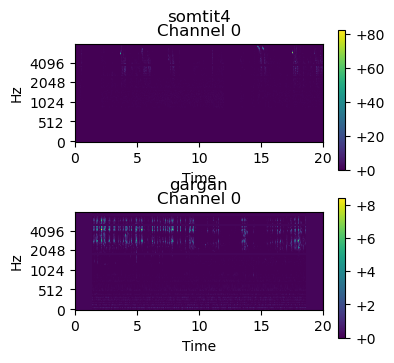

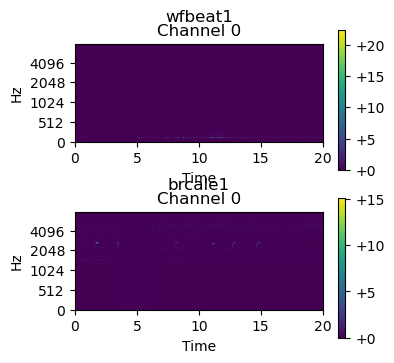

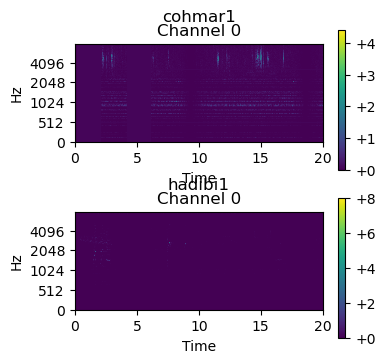

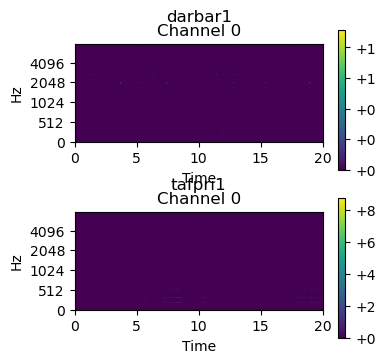

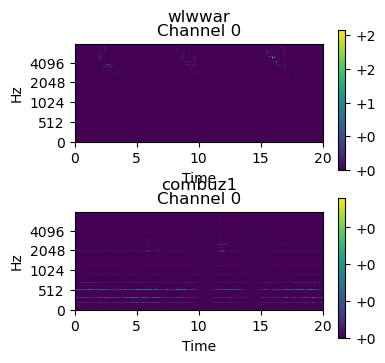

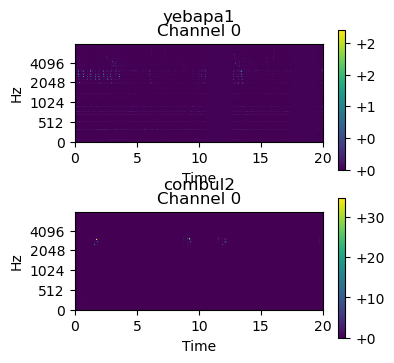

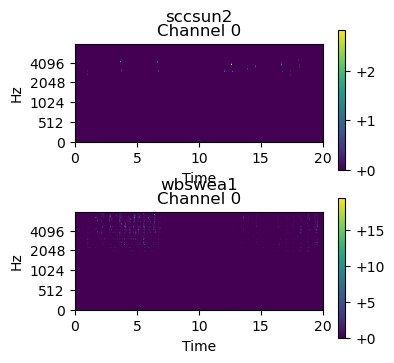

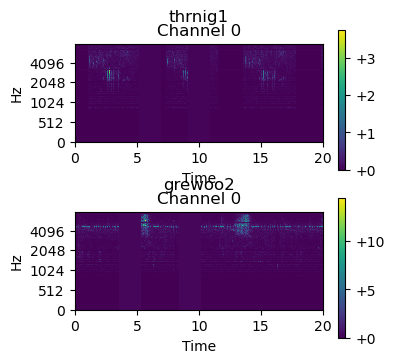

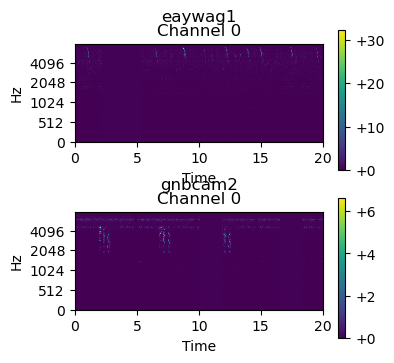

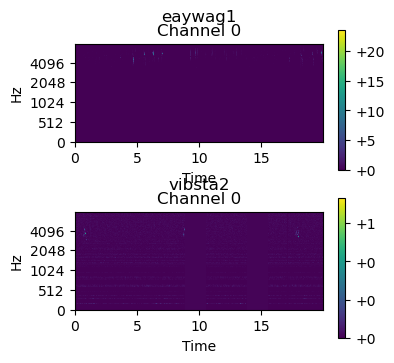

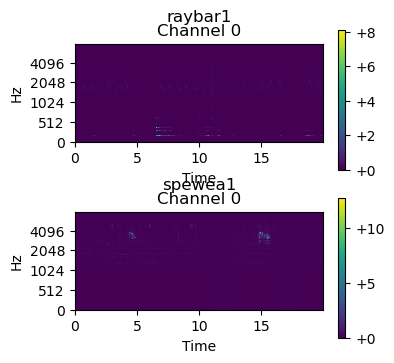

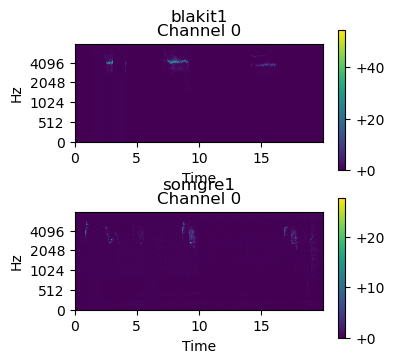

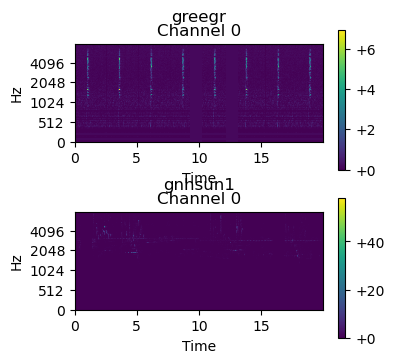

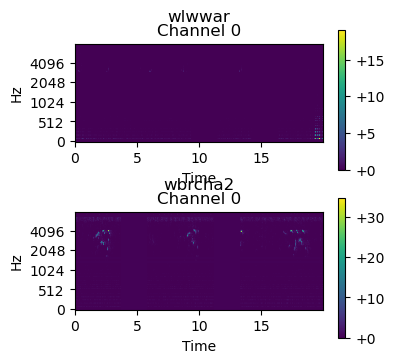

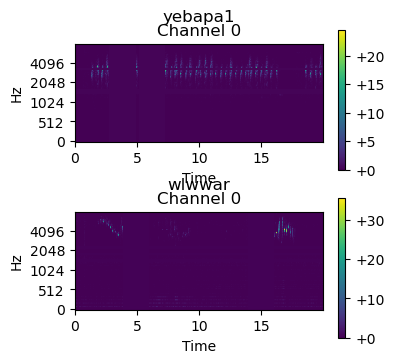

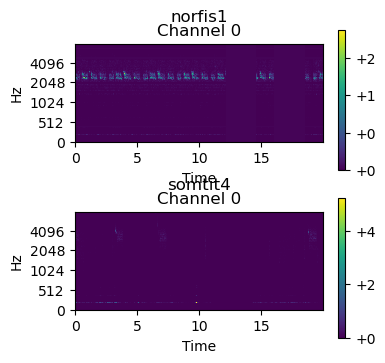

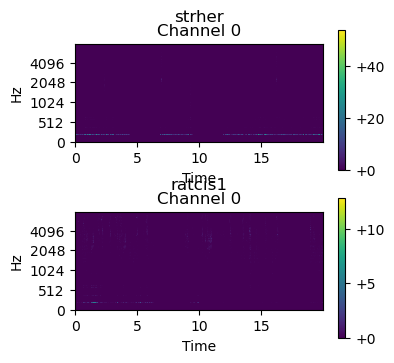

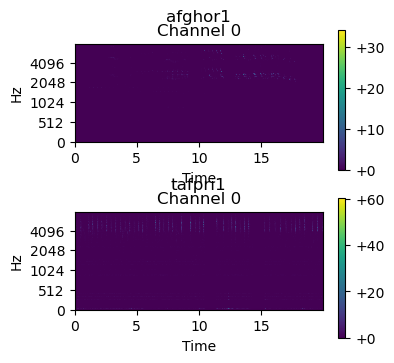

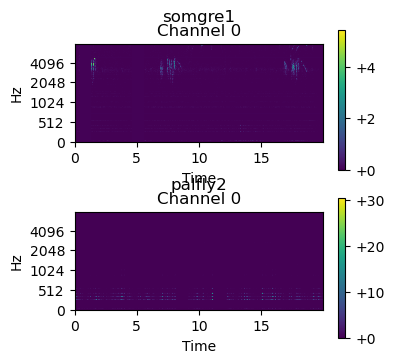

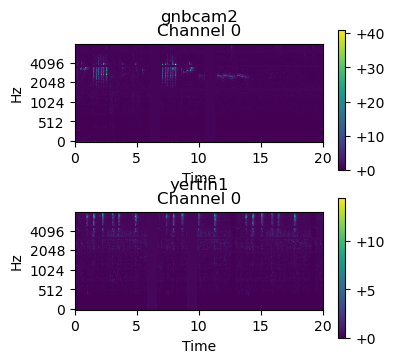

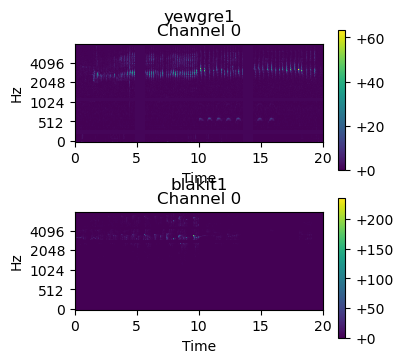

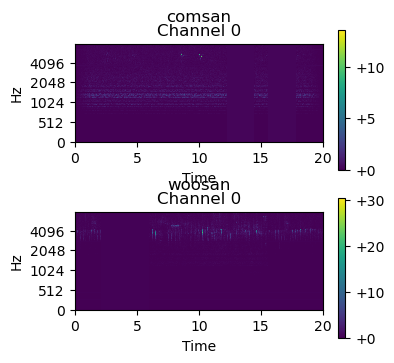

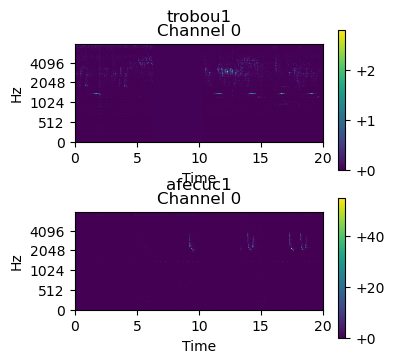

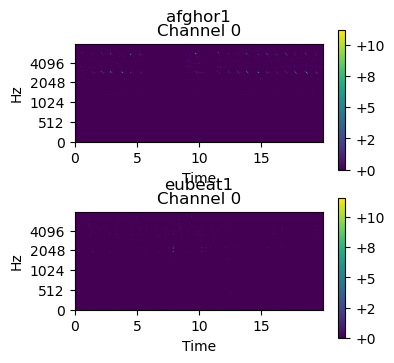

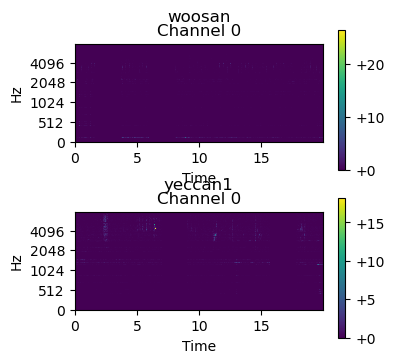

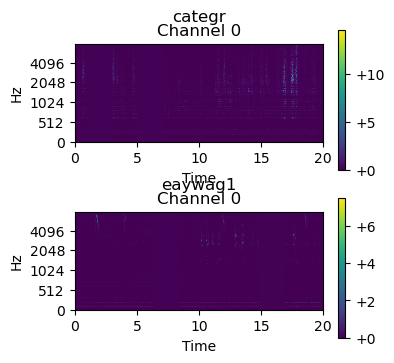

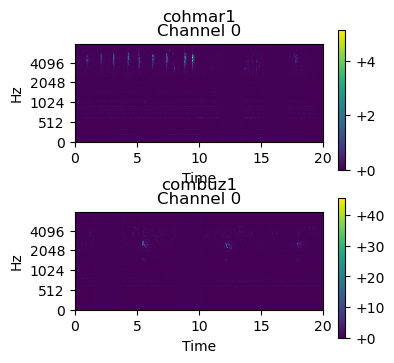

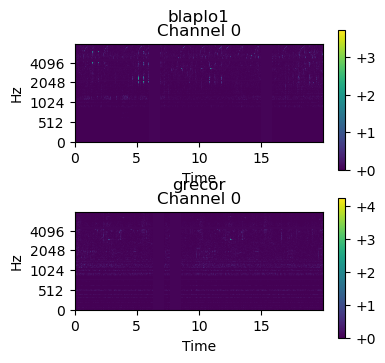

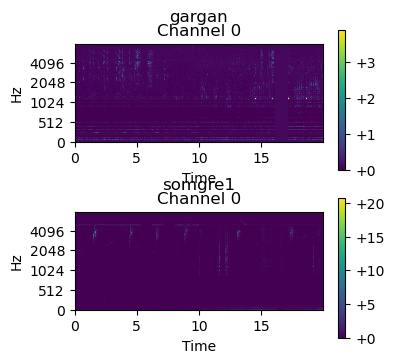

In [14]:
sweep_id = wandb.sweep(sweep_config, project=wandb_project)
wandb.agent(sweep_id, train, count=sweep_count)